In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab4.ipynb")

---

<h1><center>SDSE Lab 4 <br><br> Linear regression and Feature selection </center></h1>

---

In this lab we will use linear regression to predict cancer mortality rates based on data obtained from the American Community Survey of the [U.S. Census Bureau](https://www.census.gov/). The lab has four parts. In part 1 you will load the data and do basic manipulations using [pandas](https://pandas.pydata.org/docs/index.html). Pandas is a Python package that specializes in tabular data. It is widely used in data science and machine learning since the data in these fields are usually structured as a table. Pandas is a very powerful library that is well worth investing some time to learn [here](https://pandas.pydata.org/docs/getting_started/index.html#getting-started) and [here](https://pandas.pydata.org/docs/user_guide/index.html).

In part 2 you will perform linear regression on the full feature set. In part 3 you will compute confidence intervals and perform hypothesis tests on the paramters from part 2. Finally, in part 4 you will run the forward and backward stepwise feature selection algorithms and estimate the performance of the resulting model using a test dataset.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from resources.hashutils import *

# Part 1:  Loading and cleaning the data

## 1.1 Load the data into a pandas DataFrame

See a description of the data [here](https://data.world/nrippner/ols-regression-challenge).

Use [pd.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) to load the data from `resources/cancerdata.csv`.

You can obtain information about the data using these DataFrame methods:
+ `data0.head()` to see the first 5 rows of the DataFrame.
+ `data0.tail()` to see the last 5 rows of the DataFrame.
+ `data0.shape` is the tuple (number of rows, number of columns).
+ `data0.columns` contains the column labels.
+ `data0.index` contains the row labels.

In [3]:
data0 = pd.read_csv('resources/cancerdata.csv')

## 1.2 Inspect columns

Run `data0.info()` and note:
 a) which inputs are non-numerical (Dtype=object), and
 b) which inputs have null entries (Non-Null Count<3047).

Store the names ('Column' entry) of the non-numerical inputs in the set `non_numerical_inputs`. Store the names of inputs with null entries in the set `null_entry_inputs`.

**Note**: If not all of the rows of `data0.info()` are displayed, you'll probably have this message at the bottom:

*``Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...''*

In [4]:
data0.info()
non_numerical_inputs = {'binnedinc', 'geography'}
null_entry_inputs = {'pctsomecol18_24', 'pctemployed16_over', 'pctprivatecoveragealone'}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3047 entries, 0 to 3046
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   target_deathrate         3047 non-null   float64
 1   incidencerate            3047 non-null   float64
 2   medincome                3047 non-null   int64  
 3   povertypercent           3047 non-null   float64
 4   binnedinc                3047 non-null   object 
 5   medianage                3047 non-null   float64
 6   geography                3047 non-null   object 
 7   avghouseholdsize         3047 non-null   float64
 8   percentmarried           3047 non-null   float64
 9   pctnohs18_24             3047 non-null   float64
 10  pcths18_24               3047 non-null   float64
 11  pctsomecol18_24          762 non-null    float64
 12  pctbachdeg18_24          3047 non-null   float64
 13  pcths25_over             3047 non-null   float64
 14  pctbachdeg25_over       

In [5]:
grader.check("q1p2")

q1p2 results: All test cases passed!

## 1.3 Discard non-numerical columns

Remove the two columns with non-numeric data.

Hints:
+ `data0.dtypes` lists the data types for each column.
+ You can construct a boolean indicator array of non-numeric colums with `data0.dtypes=='object'`.
+ Use that array to index `data.columns`
+ Use [`data0.drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) to remove the selected columns.
+ Save the result as `data1`

In [6]:
non_numeric_columns = data0.columns[data0.dtypes == 'object']
data1 = data0.drop(non_numeric_columns, axis=1)

In [7]:
grader.check("q1p3")

q1p3 results: All test cases passed!

## 1.4 Discard columns where more than 10% of values are nan

Hints:
+ [`.dropna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)
+ `axis=1` ... we are dropping columns
+ `thresh` ... The condition for dropping a column is that it has less than `round(0.9*data1.shape[0])` non-nans.
+ Save the result as `data2`


In [8]:
thresh = round(0.9 * data1.shape[0])

# Drop columns with less than 90% non-NaN values
data2 = data1.dropna(axis=1, thresh=thresh)

# Check the shape of the resulting DataFrame
data2.shape

(3047, 24)

In [9]:
grader.check("q1p4")

q1p4 results: All test cases passed!

## 1.5 Drop all rows that contain one or more nans.

Save the result as `data3`.

Hint: You can again use `dropna` for this.

In [10]:
data3 = data2.dropna()

In [11]:
grader.check("q1p5")

q1p5 results: All test cases passed!

## 1.6 Inspect correlations

Next we'll look at the correlation coefficients between each of the inputs and the target variable `target_deathrate`. This is a quick way to check which of the inputs may be most useful to include in the model. Correlations only provide an initial guess, however. Remember that the correlation coefficient only measures the linear relationship between variables. That's perfect when the model is linear (as in this lab activity), but less useful for nonlinear models.

1) Use `data3.corr()` to build the correlations matrix.
2) Inspect the column (or row) corresponding to `target_deathrate`.
3) Rank (i.e. sort) the inputs from most to least correlated with the output. This ranking is in terms of the absolute value of the correlation coefficient.
4) Save the top 5 correlated inputs to `top_5_corr`. `top_5_corr` should be a numpy array with shape `(5,)`.

Hints:
+ [`abs`](https://pandas.pydata.org/docs/reference/api/pandas.Series.abs.html)
+ [`sort_values`](https://pandas.pydata.org/docs/reference/api/pandas.Series.sort_values.html)
+ [`to_numpy`](https://pandas.pydata.org/docs/reference/api/pandas.Series.to_numpy.html)

In [12]:
# correlation matrix
C = data3.corr()  # Compute the full correlation matrix for data3

# vector correlations between the inputs and target_deathrate
corr_target = C['target_deathrate'].drop('target_deathrate')  # Extract correlations with target_deathrate, excluding itself

# sorted corr_target_sort
corr_target_sort = corr_target.abs().sort_values(ascending=False)  # Take absolute values and sort in descending order

# top 5 correlations with target_deathrate
top_5_sort = corr_target_sort.head(5).index.to_numpy()  # Select the top 5 correlated features and convert to numpy array

In [13]:
grader.check("q1p6")

q1p6 results: All test cases passed!

## 1.7 Scatter plot

Make a scatter plot of the data with the most correlated input along the x axis, and the target along the y axis.

Hint: You can use the plotting function attached to the DataFrame: [data.plot(kind='scatter',x=..., y=...)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

<Axes: xlabel='pctbachdeg25_over', ylabel='target_deathrate'>

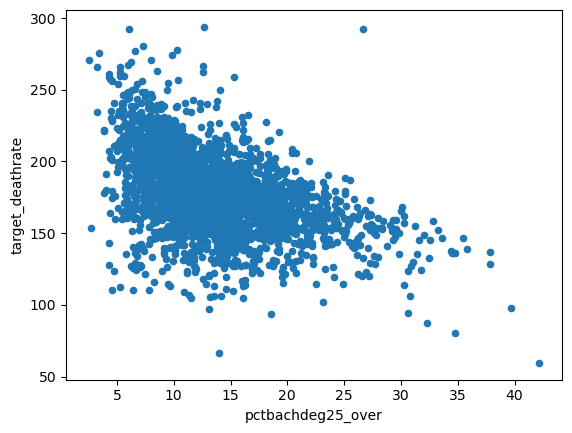

In [14]:
data3.plot(kind='scatter',x=top_5_sort[0], y='target_deathrate')

---

# Part 2: Linear regression 

## 2.1 Extract `X` and `Y` from `data3`

The next cell extracts the `X` and `Y` matrices from `data3`. It also makes a list of `inputs`, and defines the number of samples `N` and the number of inputs `P`.

In [15]:
X = data3.drop(columns='target_deathrate').values
inputs = data3.columns.values
inputs = inputs[inputs!='target_deathrate']
Y = data3['target_deathrate'].values

N = len(X)
D = len(inputs)

In [16]:
grader.check("q2p1")

q2p1 results: All test cases passed!

## 2.2 Center the inputs

\begin{align*}
\hat\mu_X &= \frac{1}{N} \mathbf{1}^T_N \mathbf{X} \\
\mathbf{X}^c&=\mathbf{X}-\mathbf{1}_N\hat\mu_X
\end{align*}

Compute the column-wise means `muhatX` and subtract them from `X` to obtain `Xc`. 

Hint: 
+ Use `X.mean(axis=...)`. Should it be `axis=0` or `axis=1`? 
+ The formula for `Xc` above has $\mathbf{1}_N\hat\mu_X$. The broadcasting rules of numpy make multiplying $\hat\mu_X$ by $\mathbf{1}_N$ unnecessary.

Check that the column-wise means of `Xc` equal zero (to machine precision). 

In [17]:
muhatX = X.mean(axis=0)
Xc = X - muhatX

In [18]:
grader.check("q2p2")

q2p2 results: All test cases passed!

## 2.3 Center the outputs

\begin{align*}
\hat\mu_Y &= \frac{1}{N} \mathbf{1}^T_N \mathbf{Y} \\
\mathbf{Y}^c&=\mathbf{Y}-\mathbf{1}_N\hat\mu_Y
\end{align*}


In [19]:
muhatY = Y.mean(axis=0)
Yc = Y - muhatY

In [20]:
grader.check("q2p3")

q2p3 results: All test cases passed!

## 2.4 Compute the inverse input covariance martrix.


$$\Sigma^{-1}_X=( (\mathbf{X}^c)^T \mathbf{X}^c)^{-1}$$

Hints:
+ numpy's @ operator and matrix transposition (`Xc.T`). See [this](https://numpy.org/devdocs/user/numpy-for-matlab-users.html) summary of the key differences between numpy and Matlab.
+ [np.linalg.inv](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html)


In [21]:
invCovX = np.linalg.inv(Xc.T @ Xc)

In [22]:
grader.check("q2p4")

q2p4 results: All test cases passed!

## 2.5 Compute the least squares estimates of the parameters

\begin{align*}
\underline{\hat\theta}_1 &= \Sigma^{-1}_X(\mathbf{X}^c)^{T} \mathbf{Y}^c \\
\hat\theta_0 &= \hat\mu_Y - \hat\mu_X \underline{\hat\theta}_1
\end{align*}

In [23]:
theta1hat = invCovX@Xc.T@Yc
theta0hat = muhatY - muhatX@theta1hat

In [24]:
grader.check("q2p5")

q2p5 results: All test cases passed!

## 2.6 Compute predictions for each of the samples

$$\mathbf{\hat{Y}} = \mathbf{1}_N\hat\theta_0 + \mathbf{X}\underline{\hat\theta}_1$$


In [25]:
Yhat = theta0hat + X@theta1hat

In [26]:
grader.check("q2p6")

q2p6 results: All test cases passed!

## 2.7 Model performance

Compute the coefficient of determination $R^2$ for this model on the trainging data.

$$ R^2 = 1 - \frac{\sum_{i=1}^N (y_i-\hat{y}_i)^2}{\sum_{i=1}^N (y_i-\hat\mu_Y)^2}$$

In [27]:
ss_res = ((Y - Yhat) ** 2).sum()
ss_tot = ((Y - muhatY) ** 2).sum()

R2 = 1 - (ss_res / ss_tot)

In [28]:
grader.check("q2p7")

q2p7 results: All test cases passed!

---

# Part 3: Parameter uncertainty

## 3.1 Estimate the variance of the output

$$\hat\sigma^2 = \frac{1}{N-D-1} \sum_{i=1}^{N}(y_i-\hat{y}_i)^2$$

In [29]:
sigmahat2 = (1/(N-D-1))*ss_res

In [30]:
grader.check("q3p1")

q3p1 results: All test cases passed!

## 3.2 Compute the variances of the slope parameters

These are the diagonal entries of 
$$Var[\underline{\hat\Theta}_1] = \hat\sigma^2 \Sigma^{-1}_X $$

In other words, the variance of $\hat\theta_p$ is the $p$'th diagonal entry of $Var[\underline{\hat\Theta}_1]$.

**Hint**: [`np.diag`](https://numpy.org/doc/stable/reference/generated/numpy.diag.html)

In [31]:
var_thetahat = np.diag(sigmahat2*invCovX)

In [32]:
grader.check("q3p2")

q3p2 results: All test cases passed!

## 3.3 Compute the radiuses of the confidence intervals

We know that all of the parameters are Gaussian with variance given by the $p$'th diagonal entry in $\hat\sigma^2 \Sigma^{-1}_X$. We denote this variance as $v_p$. Then $v_p$ is the $p$-th entry in `var_thetahat`. 

Compute the radiuses of the 95\% confidence intervals for the slope parameters $\underline{\hat\theta}_1$ with:

$$\rho =\sqrt{Var[\underline{\hat\Theta}_1] } \left| F^{-1}_{\mathcal{N}}\left( \frac{1-\gamma}{2}\right)\right| $$



In [33]:
from scipy.stats import norm

gamma = 0.95
critical_value = norm.ppf(1 - (1 - gamma) / 2)

rho = np.sqrt(var_thetahat) * critical_value

In [34]:
grader.check("q3p3")

q3p3 results: All test cases passed!

## 3.4 Tag as "significant" those parameters whose confidence interval does not include zero.

Create a 1D NumPy boolean array of the same size as `theta1hat` called `significant`. The $i$'th entry of `significant` should be `True` if the 95\% confidence interval for the corresponding slope parameter **does not** include 0, and `False` otherwise. In other words, an input is considered significant if its slope parameter is non-zero with a high degree of confidence. 

In [35]:
significant = (theta1hat - rho > 0) | (theta1hat + rho < 0)

In [36]:
grader.check("q3p4")

q3p4 results: All test cases passed!

## 3.5 Parameters table (done already)
Make a DataFrame with one row for each input. The index of the table should be the input names. The columns should be:
+ `slope`: the estimates of the slope parameter associated with the input. 
+ `slope stddev`: the standard deviation of the slope parameter.
+ `significant`: whether the input is significant according to part 3.4.

In [37]:
params_table = pd.DataFrame(index=inputs,
             data={'slope':theta1hat,
                   'slope stddev':np.sqrt(var_thetahat),
                   'significant':significant})

params_table

,slope,slope stddev,significant
incidencerate,0.187506,0.007661,True
medincome,0.000036,0.000082,False
povertypercent,0.291682,0.161699,False
medianage,-0.005219,0.008185,False
avghouseholdsize,0.797012,0.989947,False
percentmarried,1.166145,0.166061,True
pctnohs18_24,-0.194668,0.057114,True
pcths18_24,0.183444,0.050269,True
pctbachdeg18_24,-0.114888,0.110064,False
pcths25_over,0.369317,0.098170,True


## 3.6 Build an array of significant inputs

Extract the names of the significant inputs (i.e. inputs) from `params_table` using the `significant` array from part 3.4.

Store these significant input names as `significant_inputs`. `significant_inputs` should be a NumPy array with shape `(15,)`.

Here's one way you can do this that doesn't involve "for" loops:
1. Use the `significant` column to select the rows of the table corresponding to significant inputs. 
2. Use `.index` to obtain the names of the inputs for those rows. 
3. Use `.to_numpy()` to convert the result to a NumPy array.

In [38]:
significant_inputs = params_table[params_table['significant'] == True].index.to_numpy()

In [39]:
grader.check("q3p6")

q3p6 results: All test cases passed!

## 3.7 Create a new table with significant inputs only (done already)

This table is called `data` and the target variable is now called `Y`.

In [40]:
data = data3[significant_inputs].copy()
data['Y'] = data3['target_deathrate']
data

,incidencerate,percentmarried,pctnohs18_24,pcths18_24,pcths25_over,pctbachdeg25_over,pctemployed16_over,pctprivatecoverage,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctotherrace,pctmarriedhouseholds,birthrate,Y
0,489.800000,52.5,11.5,39.5,23.2,19.6,51.9,75.1,41.6,32.9,14.0,81.780529,1.843479,52.856076,6.118831,164.9
1,411.600000,44.5,6.1,22.4,26.0,22.7,55.9,70.2,43.6,31.1,15.3,89.228509,3.741352,45.372500,4.333096,161.3
2,349.700000,54.2,24.0,36.6,29.0,16.0,45.9,63.7,34.9,42.1,21.1,90.922190,2.747358,54.444868,3.729488,174.7
3,430.400000,52.7,20.2,41.2,31.6,9.3,48.3,58.4,35.0,45.3,25.0,91.744686,1.362643,51.021514,4.603841,194.8
4,350.100000,57.8,14.9,43.0,33.4,15.0,48.2,61.6,35.1,44.0,22.7,94.104024,0.492135,54.027460,6.796657,144.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3041,453.549422,45.1,2.9,17.7,27.7,21.9,68.6,80.0,52.9,24.3,9.5,94.291726,1.014038,43.276779,3.977583,146.4
3042,453.549422,51.0,20.9,27.9,32.2,15.2,51.7,78.3,44.6,31.7,13.2,90.280811,1.700468,51.063830,7.773512,149.6
3043,453.549422,52.6,26.7,33.9,23.1,12.4,70.1,64.5,48.6,28.8,17.7,75.706245,14.130288,52.007937,8.186470,150.1
3044,453.549422,54.8,19.7,44.5,23.0,12.8,64.8,62.0,47.8,26.6,16.8,87.961629,5.680705,55.153949,7.809192,153.9


---

# Part 4: Feature subset selection 

## 4.1 Split `data` into training, validation, and testing datasets

We will use 70% of the data for training, 15% for validation, and 15% for testing.

1. Define `Dtrain` as the first `Ntrain` rows of `data`.
2. Define `Dvalidate` as the next `Nvalidate` rows of `data`.
3. Define `Dtest` as the last `Ntest` rows of `data`.

Here we use pandas' [iloc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html) method for selecting the three datasets.

In [41]:
Ntrain = round(0.7*N)
Nvalidate = round(0.15*N)
Ntest = N - Ntrain - Nvalidate
Ntrain, Nvalidate, Ntest

Dtrain = data.iloc[:Ntrain,:]
Dvalidate = data.iloc[Ntrain:Ntrain+Nvalidate,:]
Dtest = data.iloc[Ntrain+Nvalidate:,:]

## 4.2 Linear regression training function

Create a function called `train` that receives a list of features `S` and a dataset `Dtrain` and does the following:
1. Selects the features `S` from `D` and stores them in `X`. (done already)
2. Selects the target values from `D` and stores them in `Y`. (done already)
3. Performs the linear regression calculations from parts 2.2, 2.3, and 2.4
4. Returns the estimated parameters $\hat\theta$

In [42]:
def train(S, Dtrain):

    X = Dtrain[list(S)].values
    Y = Dtrain['Y'].values

    # 2.2 Center the inputs 
    muhatX = X.mean(axis=0)
    Xc = X - muhatX

    # 2.3 Center the outputs 
    muhatY = Y.mean(axis=0)
    Yc = Y - muhatY

    # 2.4 Compute the inverse input covariance matrix
    invCovX = np.linalg.inv(Xc.T @ Xc)

    # 2.5 Compute the least squares estimates of the parameters
    theta1hat = invCovX@Xc.T@Yc
    theta0hat = muhatY - muhatX@theta1hat

    return theta0hat, theta1hat

In [43]:
theta0hat, theta1hat = train(['incidencerate','birthrate'], Dtrain)

In [44]:
grader.check("q4p2")

q4p2 results: All test cases passed!

## 4.3 Model evaluation function

Create a function called `perf` that receives the linear regression parameters `theta0hat` and `theta1hat`, their corresponding feature names `S`, and a dataset `D`, which may be the validation or the training dataset.

The function should evluate the means squared error (MSE) for the model using this data.

The steps are:
1. Select the features `S` from `D` and stores them in `X`. (done already)
2. Select the target values from `D` and stores them in `Y`. (done already)
3. Compute `Yhat`, as in part 2.6.
4. Use the MSE as the performance metric:

$$MSE = \frac{1}{N}\sum_{i=1}^{N} ( y_i-\hat{y}_i)^2$$

In [45]:
def perf( S, theta0hat, theta1hat, D):

    X = D[list(S)].values
    Y = D['Y'].values

    # 2.6 Compute predictions for each of the samples
    Yhat = theta0hat + X@theta1hat

    # 2.7 Model performance
    MSE = ((Y - Yhat) ** 2).mean()
    
    return MSE

In [46]:
theta0hat, theta1hat = train(['incidencerate','birthrate'], Dtrain)
perf(['incidencerate','birthrate'], theta0hat, theta1hat, Dtrain)

609.6921443878825

In [47]:
grader.check("q4p3")

q4p3 results: All test cases passed!

## 4.4 Forward stepwise selection

Following is the code for forward stepwise feature selection that was described in the lab. When you run it, it will store the solution in variables with names `f_*`.

This part has no deliverables.

In [48]:
P = len(significant_inputs)
curlyP = set(significant_inputs)

In [49]:
curlyS = [set() for i in range(P+1)]
ellk = np.full(P+1,np.inf)

for k in range(1,P+1):
    
    curlyA = [set() for i in range(P-k+1)]
    ellkappa = np.full(P-k+1,np.inf)

    for kappa, phip in enumerate(curlyP-curlyS[k-1]):
        curlyA[kappa] = curlyS[k-1].union({phip})
        theta0hat, theta1hat = train( curlyA[kappa] , Dtrain)
        ellkappa[kappa] = perf(curlyA[kappa], theta0hat, theta1hat, 
                               Dvalidate)

    kappastar = ellkappa.argmin()
    curlyS[k] = curlyA[kappastar]
    ellk[k] = ellkappa[kappastar]

kstar = ellk.argmin()
Sstar = curlyS[kstar]
theta0star, theta1star = train(Sstar, Dtrain)
ellstar = perf(Sstar, theta0star, theta1star, Dtest)

# Store the results
f_ellk = ellk
f_ellstar = ellstar
f_kstar = kstar

## 4.5 Backward stepwise selection

Complete the code for backward stepwise selection.

In [61]:
curlyS = [set() for i in range(P+1)]
curlyS[P] = set(significant_inputs)
ellk = np.full(P+1, np.inf)

for k in range(P, 0, -1):

    curlyA = [set() for i in range(k)]
    ellkappa = np.full(k, np.inf)

    for kappa, phip in enumerate(curlyS[k]):
        curlyA[kappa] = curlyS[k] - {phip}
        theta0hat, theta1hat = train(curlyA[kappa], Dtrain)
        ellkappa[kappa] = perf(curlyA[kappa], theta0hat, theta1hat, Dvalidate)

    kappastar = ellkappa.argmin()
    curlyS[k-1] = curlyA[kappastar]
    ellk[k-1] = ellkappa[kappastar]

kstar = ellk.argmin()
Sstar = curlyS[kstar]
theta0star, theta1star = train(Sstar, Dtrain)
ellstar = perf(Sstar, theta0star, theta1star, Dtest)

# Store the results
b_ellk = ellk
b_ellstar = ellstar
b_kstar = kstar

In [62]:
grader.check("q4p5")

q4p5 results: All test cases passed!

## Plot

The following plot shows the results of forward and backward stepwise feature selection for this regression problem. In each case, the star indicates the test error for the model with the smallest validation error.

Text(0, 0.5, 'MSE')

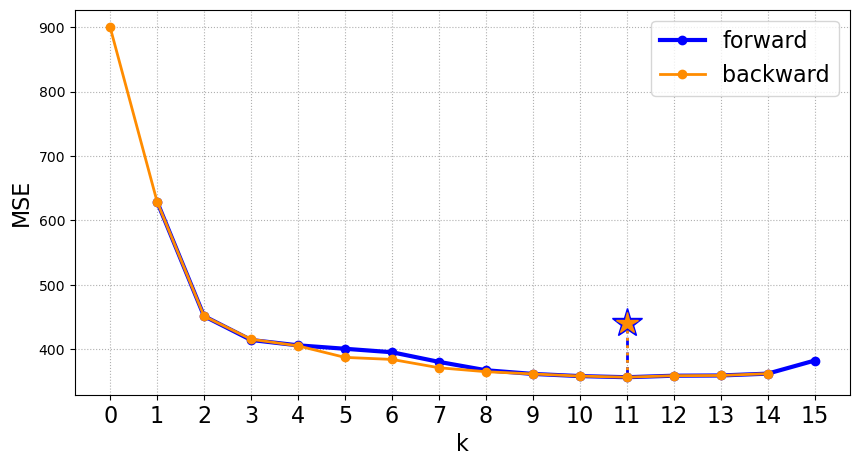

In [63]:
plt.figure(figsize=(10,5))

plt.plot(range(P+1),f_ellk,'o-',color='blue',label='forward',linewidth=3)
plt.plot([f_kstar,f_kstar],[f_ellk[f_kstar],f_ellstar],color='blue',linestyle='--',linewidth=2)
plt.plot(f_kstar,f_ellstar,'*',color='blue',markersize=22)

c = 'darkorange'
plt.plot(range(P+1),b_ellk,'o-',color=c,label='backward',linewidth=2)
plt.plot([b_kstar,b_kstar],[b_ellk[b_kstar],b_ellstar],color=c,linestyle=':',linewidth=2)
plt.plot(b_kstar,b_ellstar,'*',color=c,markersize=16)
plt.legend(fontsize=16)

plt.grid(linestyle=':')

# plt.ylim(340,480)
# plt.xlim(0,16)
plt.xticks(range(16),fontsize=16)
plt.xlabel('k',fontsize=16)
plt.ylabel('MSE',fontsize=16)

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Make sure you submit the .zip file to Gradescope.

In [64]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)